Import dependencies

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras
from keras.utils import plot_model
import math
from keras.optimizers import RMSprop

2023-02-01 15:21:05.061838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:21:05.186466: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 15:21:05.839773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-01 15:21:05.839866

Set parameters and load the data

In [2]:
Img_shape = 28
Num_classes = 10
test_size = 0.25
random_state = 0
No_epochs = 100
Batch_size = 128

In [3]:
train_dataset = pd.read_csv("fashion-mnist_train.csv")
test_dataset = pd.read_csv("fashion-mnist_test.csv")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [4]:
def data_preprocessing(raw):
    label = tf.keras.utils.to_categorical(raw.label, 10)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, 28, 28, 1)
    image = x_shaped_array / 255
    return image, label

X, y = data_preprocessing(train_dataset)
X_test, y_test = data_preprocessing(test_dataset)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

Initialize teacher model

In [5]:
teacher_model = tf.keras.models.load_model('init_model')

2023-02-01 15:21:12.747349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13582 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-02-01 15:21:12.751621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1057 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:d8:00.0, compute capability: 7.5


Teacher code has the same architecture as the initial mode, here the code is just for the comparison with the student)

In [6]:
teacher_model = tf.keras.Sequential()

teacher_model.add(Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_normal', input_shape=(28,28, 1)))
teacher_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


teacher_model.add(Conv2D(64, 3, padding='same', activation='relu'))
teacher_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

teacher_model.add(Dropout(0.3))
teacher_model.add(BatchNormalization())
teacher_model.add(Conv2D(128, 3, padding='same', activation='relu'))
teacher_model.add(Conv2D(128, 3, padding='same', activation='relu'))
teacher_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

teacher_model.add(Dropout(0.4))
teacher_model.add(Flatten())
teacher_model.add(BatchNormalization())
teacher_model.add(Dense(512, activation='relu'))

teacher_model.add(Dropout(0.25))
teacher_model.add(Dense(10, activation='softmax'))

In [7]:
score = teacher_model.evaluate(X_test, y_test, steps = math.ceil(10000/32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2023-02-01 15:21:14.863868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400


313/313 [==============================] - 4s 6ms/step - loss: 0.2374 - accuracy: 0.9376
Test loss: 0.237412229180336
Test accuracy: 0.9376000165939331


Initialize the student - the student architecture is different from the teacher

In [12]:
# student_model = tf.keras.Sequential()

# student_model.add(Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_normal', input_shape=(28,28, 1)))
# student_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# student_model.add(Conv2D(64, 3, padding='same', activation='relu'))
# student_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# student_model.add(Dropout(0.3))
# student_model.add(BatchNormalization())
# student_model.add(Conv2D(128, 3, padding='same', activation='relu'))
# student_model.add(Conv2D(128, 3, padding='same', activation='relu'))
# student_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# student_model.add(Dropout(0.4))
# student_model.add(Flatten())
# student_model.add(BatchNormalization())
# student_model.add(Dense(512, activation='relu'))

# student_model.add(Dropout(0.25))
# student_model.add(Dense(10, activation='softmax'))

In [46]:
student_model = tf.keras.Sequential()

student_model.add(Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal', input_shape=(28,28, 1)))
student_model.add(BatchNormalization())
student_model.add(Conv2D(32, 3, padding='same', activation='relu'))
student_model.add(BatchNormalization())
student_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
student_model.add(Dropout(0.5))

student_model.add(Conv2D(64, 3, padding='same', activation='relu'))
student_model.add(BatchNormalization())
student_model.add(Conv2D(64, 3, padding='same', activation='relu'))
student_model.add(BatchNormalization())
student_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
student_model.add(Dropout(0.5))

student_model.add(Flatten())
student_model.add(Dense(512, activation='relu'))
student_model.add(Dropout(0.5))
student_model.add(Dense(10, activation='softmax'))

In [47]:
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [48]:
soft_labels = teacher_model.predict(X_train)

1407/1407 [==============================] - 6s 4ms/step


In [ ]:
student_model.fit(X_train, soft_labels,
                  batch_size=Batch_size,
                  epochs=No_epochs,
                  verbose=1,
                  validation_data=(X_val, y_val))


In [66]:
student_model.save('stud_model_diff_from_teacher')

INFO:tensorflow:Assets written to: stud_model_diff_from_teacher/assets


INFO:tensorflow:Assets written to: stud_model_diff_from_teacher/assets


In [121]:
student_model_same = tf.keras.models.load_model('stud_model_same_as_teacher')

Initial accuracy for both models

In [67]:
score = teacher_model.evaluate(X_test, y_test, steps = math.ceil(10000/32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.2374 - accuracy: 0.9376
Test loss: 0.237412229180336
Test accuracy: 0.9376000165939331


In [120]:
score = student_model_same.evaluate(X_test, y_test, steps = math.ceil(10000/32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.1870 - accuracy: 0.9368
Test loss: 0.1869979053735733
Test accuracy: 0.9368000030517578


Performance against the adversarial attacks

In [132]:
#load the attack
import pickle
file = open('image_iterate_list_one', 'rb')
X_list = pickle.load(file)
file.close()

In [133]:
loss_teacher = []
acc_teacher = []
loss_student = []
acc_student = []
loss_student_same = []

acc_student_same = []
eps = [0.001,0.01,0.05, 0.1, 0.15, 0.2]
# eps = [0.0001, 0.001]

for e in range(len(eps)): 
    img_new = np.concatenate(X_list[e], axis=0)
    score_teacher = teacher_model.evaluate(img_new, y_test, steps=math.ceil(10000/32))
    score_student = student_model.evaluate(img_new, y_test, steps=math.ceil(10000/32))
    score_student_same = student_model_same.evaluate(img_new, y_test, steps=math.ceil(10000/32))
    loss_teacher.append(score_teacher[0])
    acc_teacher.append(score_teacher[1])
    loss_student.append(score_student[0])
    acc_student.append(score_student[1])
    loss_student_same.append(score_student_same[0])
    acc_student_same.append(score_student_same[1])

313/313 [==============================] - 2s 6ms/step - loss: 1.0556 - accuracy: 0.6462


In [134]:
eps = [0.01,0.05, 0.1, 0.15, 0.2]


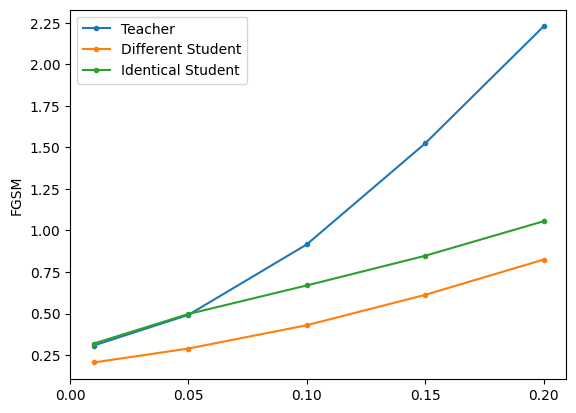

In [137]:
plt.plot(eps, loss_teacher[1:], marker=".", label = "Teacher")
plt.plot(eps, loss_student[1:], marker=".", label = "Different Student")
plt.plot(eps, loss_student_same[1:], marker=".", label = "Identical Student")
plt.legend(loc="upper left")
plt.ylabel("FGSM")
plt.xticks(np.arange(0, 0.25, step=0.05))
plt.show()

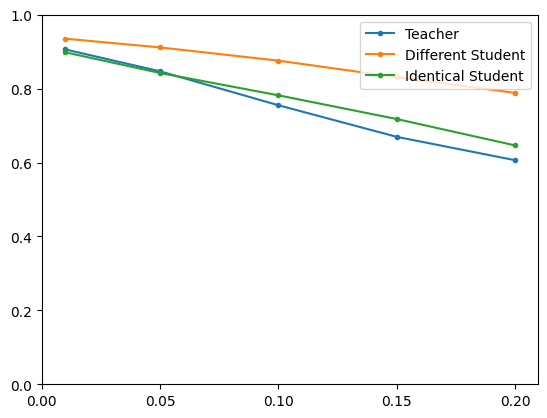

In [138]:
plt.plot(eps, acc_teacher[1:], marker=".", label = "Teacher")
plt.plot(eps, acc_student[1:], marker=".", label = "Different Student")
plt.plot(eps, acc_student_same[1:], marker=".", label = "Identical Student")
plt.legend(loc="upper right")
plt.ylim([0, 1])
plt.xticks(np.arange(0, 0.25, step=0.05))
plt.show()